In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import exp
import seaborn as sns
import plotly.graph_objects as go
import time
import random

random.seed(3)

!wget "https://drive.google.com/uc?id=15WAD9_4CpUK6EWmgWVXU8YMnyYLKQvW8&export=download" -O data.csv -q
# !wget "https://www.kaggle.com/danielfmfurlan/graduate-admission/data=download" -O data.csv -q
# Load the data
data = pd.read_csv("data.csv")
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [2]:
data.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


# Lets take a look at some graphs to better visualize these statistics

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)


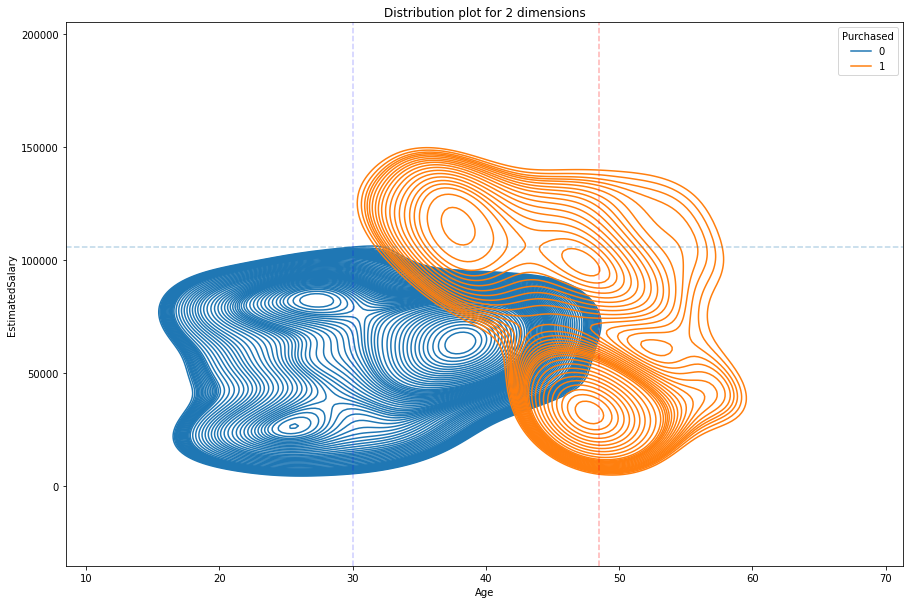

In [3]:
plt.figure(figsize=(15,10))
plt.title("Distribution plot for 2 dimensions")
sns.kdeplot(
    data=data, x="Age", y="EstimatedSalary", hue="Purchased",
    levels=75, thresh=0.2, fill = False, cmap = "mako"
)
sns.set_style("dark")
plt.axhline(y = 106000, alpha = 0.3,linestyle = "--")
plt.axvline(x = 30, alpha = 0.2,linestyle = "--", color = "blue")
plt.axvline(x = 48.5, alpha = 0.3,linestyle = "--", color = "red")

This is a nice plot telling us that while EstimatedSalary is a less discriminative variable (we can hardly distinguish if someone purchased based solely on it. The only region that we can do so is from above 106000 - the horizontal line -, where everyone purchased!), the Age has 2 separate regions: below 30y.o. and above 49 y.o. 

To have a better understanding of that, check the graph below.


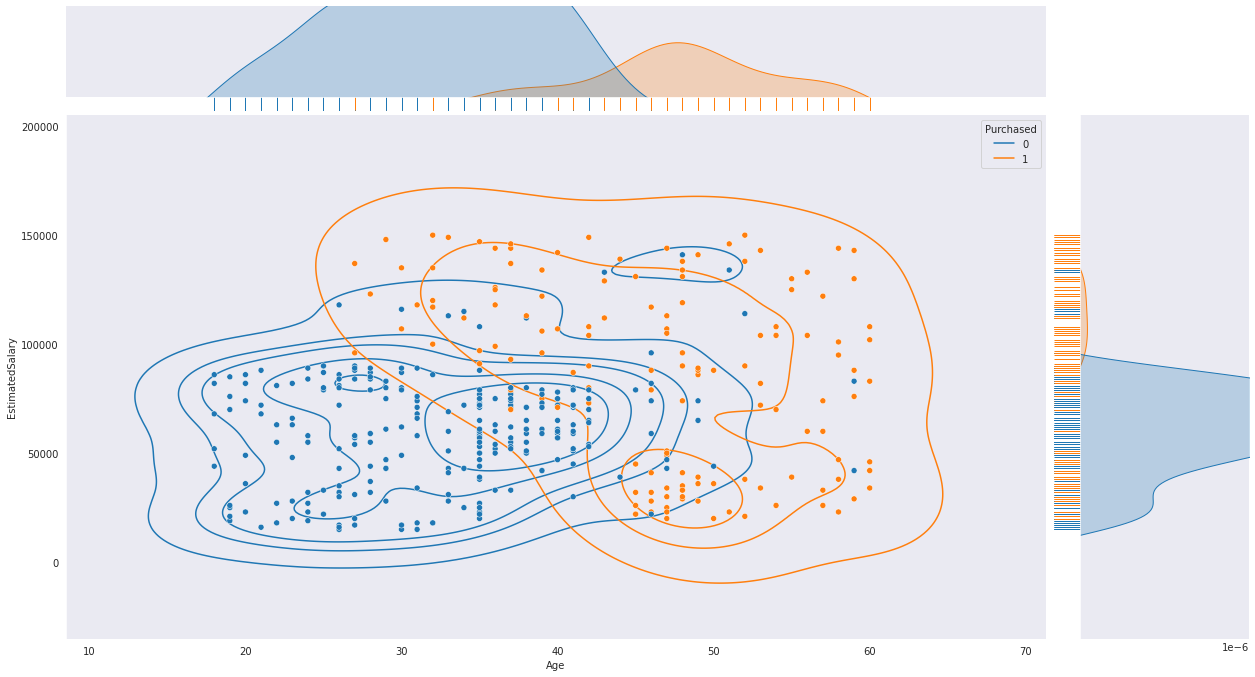

In [4]:

g = sns.jointplot(data=data, x="Age", y="EstimatedSalary", hue = "Purchased")

g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-0.15, clip_on=False)

plt.gcf().set_size_inches(19, 10)

Just for fun, let's try to visualize it in a 3D plot!

In [5]:
cols = np.sort(data.EstimatedSalary.unique())

dt = pd.DataFrame(index = [data.Age.unique()], columns = cols)
dt.sort_index(inplace=True)

val = len(data.loc[(data.Age == 50) & (data.EstimatedSalary == 28000)])


idx = dt.index.values

for col in cols:
  for age in idx:
    dt.loc[age,col] = len(data.loc[(data.Age == age[0]) & (data.EstimatedSalary == col)])

# dt

In [6]:
plt.figure(figsize=(15,10))
fig = go.Figure(data=[go.Surface(z=dt.values)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(title='3D plot distribution of Age and Estimated Salary', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=100, t=90))


fig.show()

<Figure size 1080x720 with 0 Axes>

REMARK: you may have noticed that the axes values are not correspondent to the real values! This is because it's taking as input the length of the variables and not their discrete values! In other words, the values were somehow scaled! 

What about the gender and Age? 

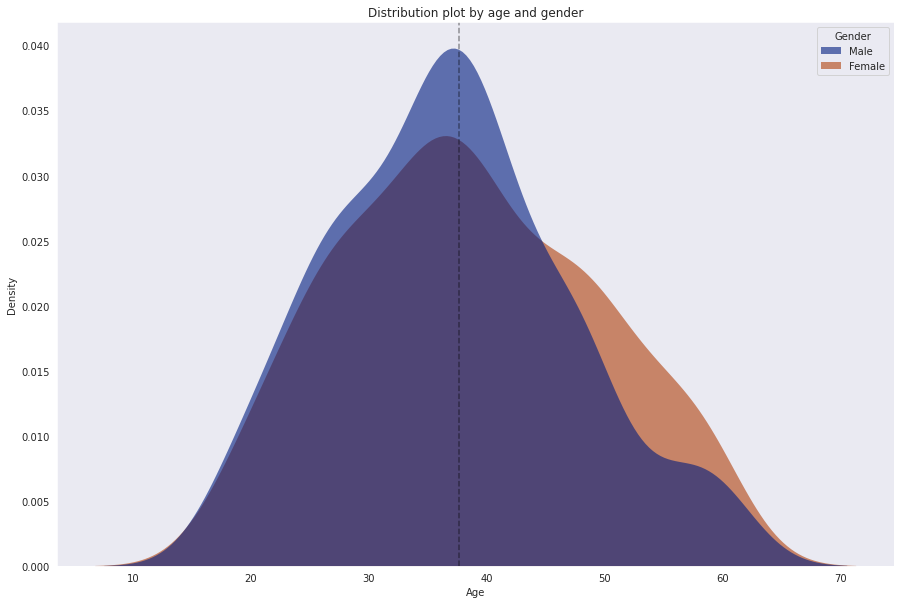

In [7]:
plt.figure(figsize=(15,10))
plt.title("Distribution plot by age and gender")
sns.kdeplot(
   data=data, x="Age", hue="Gender",
   fill=True, common_norm=False, palette="dark",
   alpha=.6, linewidth=0,
)
plt.axvline(data.Age.mean(), alpha = 0.4, color = "black", linestyle = '--', label = "Age mean")

Age and Gender have approximately the same distribution. That means a dataset well balanced for these variables. The dashed black vertical line is the mean of Age (considering both genders)

Lets now proceed to train a model and see how it can perform with a simple Logist Regression approach. The idea is to classify if someone will purchase or not based on one or more variables of interest.

In [8]:
# Divide the data to training set and test set
# Multivariate model:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:,['Age',"EstimatedSalary"]], data['Purchased'], test_size=0.20)
# Univariate model: 
# X_train, X_test, y_train, y_test = train_test_split(data.loc[:,["EstimatedSalary"]], data['Purchased'], test_size=0.20)

The variables that I will take into account here are Age and EstimatedSalary. So this is the data that our model will take in order to predict if someone will purchase.

I will train with 320 samples and test the model on 80!

In [9]:
X_train.shape, X_test.shape
# y_train.shape

((320, 2), (80, 2))

Time consumed :  0.479


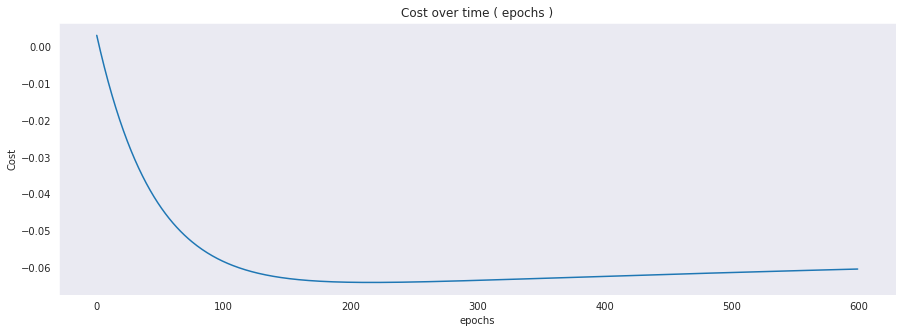

In [10]:
import math

def prediction(X,theta,mode):
    if mode == "batch":
        return np.array([1/(1 + exp(-(np.dot(x,theta))))for x in X])

    elif mode == "stoc":
        return 1/(1 + exp(-(theta[0] + theta[1]*x)))


def cost(x, y, theta,mode,pred):
    m = x.shape[0]
    
    if mode == "batch":
        return (1/m) * sum(np.transpose(y).dot(np.log(pred)) + (1 - np.transpose(y).dot(np.log(1 - pred))))
#     elif mode == "stoc":
        
def grad(x,y,theta,mode):
    epochs = 600   
    lr = 0.03
    m = x.shape[0]
    y = np.reshape(y,(y.shape[0],1))

    if x.shape[1] < 1:
      xb = np.reshape(x, (x.shape[0],1))
      xb = np.append(np.ones((xb.shape[0],1)),xb,axis=1)

    else:
      xb = np.append(np.ones((x.shape[0],1)),x,axis=1)

    J = []
    theta = np.array(np.zeros(xb.shape[1])).reshape((xb.shape[1],1))

    for _ in range(epochs):
        if mode == "batch":
            # display(type(x))
            pred = prediction(xb,theta,"batch")
            pred = np.reshape(pred,(pred.shape[0],1))

            error = 1/(2*m)*np.transpose((pred - y)).dot(xb)
            theta = theta - lr*np.reshape(error, (xb.shape[1],1))

            J.append(cost(xb,y,theta,"batch",pred)[0])

        elif mode == "stoc":
#             print("Our initial theta : ", theta)
            for i in range(m):
                pred = prediction(x[i],theta,"stoc")
                J.append((1/(2) * (y[i] - pred)**2))
                temp0 =1/m *(pred - y[i])
                temp1 = 1/m * (pred - y[i])*x[i]

                theta = theta - np.array([[temp0[0]],[temp1[0]]])*lr

    plt.figure(figsize=(15,5))
    plt.plot(J)
    plt.title("Cost over time ( epochs )")
    plt.ylabel("Cost")
    plt.xlabel("epochs")
    return theta,xb,y

x = np.array(X_train)
y = np.array(y_train)
x.shape
x = x/x.mean()
x
st = time.time()
t,x,y = grad(x,y,0,"batch")
end = time.time()
print("Time consumed : ", np.round((end-st), 3))
# grad(x,y,0,"stoc")

Now let's define a good threshold to establish which will be the value upon our model characterizes a sample as 1 or 0 (purchased or not purchased). First of all, check the balance of such values in our data: 😲

In [11]:
data.Purchased.value_counts()

0    257
1    143
Name: Purchased, dtype: int64

We can see that we have an umbalanced dataset, with near twice samples labeled 0. That said, we can't simple use a value of 0.5 for our threshold. Let's take a look at our predictions statistics to better know where the majority of them falls in: 🤽

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Predictions mean :  0.435 
Predictions min value :  0.362 
Predictions maximum value :  0.545 
Predictions standard deviation :  0.047 
Predictions median :  0.435 
Predictions 3rd quartile:  0.459


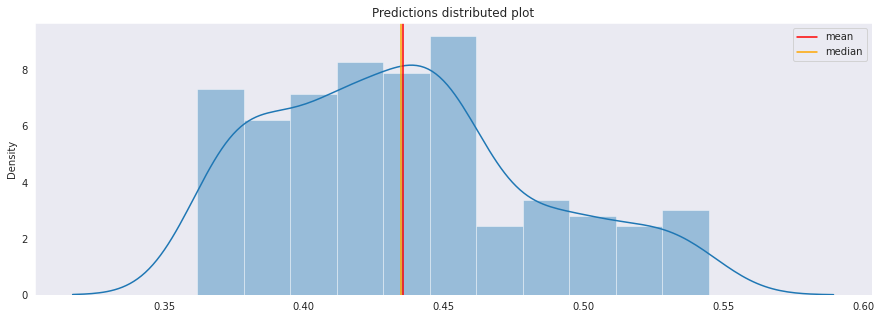

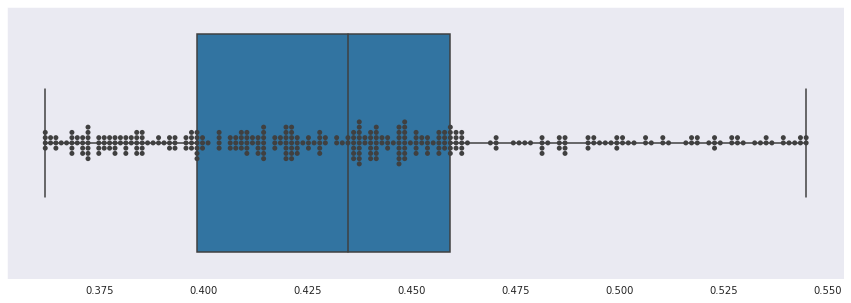

In [12]:
import seaborn as sns
import statistics

pred = prediction(x,t,"batch")

plt.figure(figsize=(15,5))
sns.distplot(pred, kde=True)
plt.axvline(x=pred.mean(),
            color='red', label = "mean")

plt.axvline(x=statistics.median(pred),
            color='orange', label = "median")

plt.legend()
plt.title("Predictions distributed plot")
plt.figure(figsize=(15,5))
sns.boxplot(pred)
sns.swarmplot(pred,color=".25")


# pred = np.array([1 if x >= 0.5 else 0 for x in pred])
print("Predictions mean : ", np.round(pred.mean(),3),"\nPredictions min value : ", np.round(pred.min(),3),"\nPredictions maximum value : ", np.round(pred.max(),3),"\nPredictions standard deviation : "
      , np.round(pred.std(),3),"\nPredictions median : ",np.round(statistics.median(pred),3),"\nPredictions 3rd quartile: ",np.round(np.quantile(pred,0.75),3))
# pred = np.array([1 if x >= pred.mean() else 0 for x in pred])


Ok! So that means 75% of our predictions are below the value of 0.445! If we have a ratio between positive and negative values of 143/257 = 0.56 (or 257/400 = 0.64 -> where 400 is the total samples in the dataset) we should take a threshold value near of the 3rd quartile so to cover the "most part of our positive cases" (in a statistical term) in the whole dataset. 


Would this interpretation be correct? You to think about it! ⛹

In [13]:
pred = np.array([1 if x >= np.quantile(pred,0.75) else 0 for x in pred])

y = np.reshape(y,(y.shape[0],))
a = np.sum(y == pred) / len(y)
print("Our final accuracy for training  : ", np.round(a,3))

xt = np.array(X_test)
yt = np.array(y_test)

xt = xt/xt.mean()
xt = np.append(np.ones((xt.shape[0],1)),xt,axis=1)

predtest = prediction(xt, t, "batch")
predtest = np.array([1 if x >= np.quantile(predtest,0.75) else 0 for x in predtest])
yt = np.reshape(yt,(yt.shape[0],))
at = np.sum(yt == predtest)/len(yt)
print("Our final accuracy for test : ", np.round(at,3))

Our final accuracy for training  :  0.791
Our final accuracy for test :  0.75


# BootStrap Sampling

What if we want to do a bootstrap sampling? Learn and test several times models in smaller portions of the dataset? This is quite convinient for big dataset (not the case here) and is always an interest approach.

In this case, I'm gonna use a Decision Tree Classifier. Is a fast dirty model that can easily learn. It can be used both for Classification and Regression problems!

Advantages: 

1.   Low computational cost
2.   Little data preparation

Disavantages:

1.   Can easily overfit, thus, not generalizing well
2.   Find the optmum decision tree can lead to a non global solution (falling in a local solution) -> can be mitigated by using a bag of trees (e.g. Random Forest Classifier)
3.   Necessary to balance the data, otherwhise, it will be biased!





I will thus perform a bootstrap sampling with only 10% of the dataset!! 
Our model will learn the data with only 40 samples!! The idea is to grab randomly 40 samples of the whole dataset with replacement (these samples can be chosen in the next time)

We repeat this process 10 times and reach an accuracy of 84% and near 95% of time ⏰ reduction!!

In [14]:
#### Bootstrap sampling

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import time

iter = 10 #### design sampling

stats = []

x = data.loc[:,["Age","EstimatedSalary","Purchased"]]
n_size = int(0.1*len(x))

x = x.values

st = time.time()
for _ in range(iter):

  train = resample(x,n_samples=n_size)

  test = np.array([row for row in x if row.tolist() not in train.tolist()])#.reshape((200,1))

  model = DecisionTreeClassifier()
  model.fit(train[:,:-1],train[:,-1])

  pred = model.predict(test[:,:-1])
  score = accuracy_score(test[:,-1],pred)
  # score
  stats.append(score)

end = time.time()
print("Time consumed : ", np.round((end - st),3))

Time consumed :  0.03


⏰

Mean of accuracies :  0.839 
Standard Deviation of accuracies :  0.035


<Figure size 1080x720 with 0 Axes>

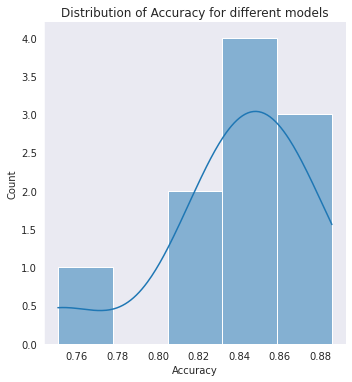

In [15]:
plt.figure(figsize=(15,10))
sns.displot(stats,kde=True).set(title = "Distribution of Accuracy for different models").set(xlabel="Accuracy")
print("Mean of accuracies : ",np.round(np.mean(stats),3),"\nStandard Deviation of accuracies : ", np.round(np.std(stats),3))

# Confidence Interval

It may be important, when performing statistical analyses, to consider a maring of error because we performances can always vary as the data been used can be different and so the model's parameters (like its weights). That said, we can't say or model will always have 84% of accuracy. It can vary as you saw in the graph above.

To do so, as the parameter of interest here is the mean of the accuracies over this repeated process, we shall use the t-Student distribution.


That said, our estimated accuracry for our entire population will be:

  EstAcc = MeanAcc +- t * std / sqrt(n)
  or
  EstAcc = MeanAcc +- MoE

where:

*   MeanAcc is the mean of the accuracies calculated previously
*   t is the value obtained from the table below
*   std is the Standard Deviation calculated previously
*   n is the size of our sample (10% of the dataset = 40 samples)
*   MoE is the "margin of error"

to get the t value: we set a confidence interval (95%) and the degree of freedom (n - 1 = 39)


---
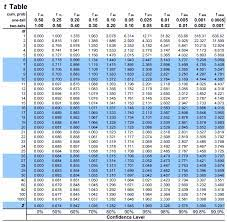

---
t ~ 2.022

MoE = 2.022 * 0.045 / sqrt(40)
MoE = 0.014 (1.4%)

EstAcc = 84% +- 1.4%

We can say thus: 
With 95% confidence we can say that the accuracy of the model representing the whole dataset will fall in the interval 82.6% and 85.4%

In other words, if we repeat this process many times, each of them grabing randomly 40 samples of the whole dataset, we would have for 95% of the cases a mean accuracy falling in between 82.6% and 85.4%
